In this notebook some image processing techniques are avlued for enhancing the PIV results. The first part is dedicated to proper contrast stretching techniques, the second to correction (removal) of areas clearly affected by an error (such as flash mirrored images).

In [1]:
# Import necessary modules
from openpiv import tools, pyprocess, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import morphology
from skimage.filters import rank
from math import *
import imageio


In [2]:
# Set variables

folder = '/home/edo20/PIV'
technique = 'standard'
# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
image_number = '052'

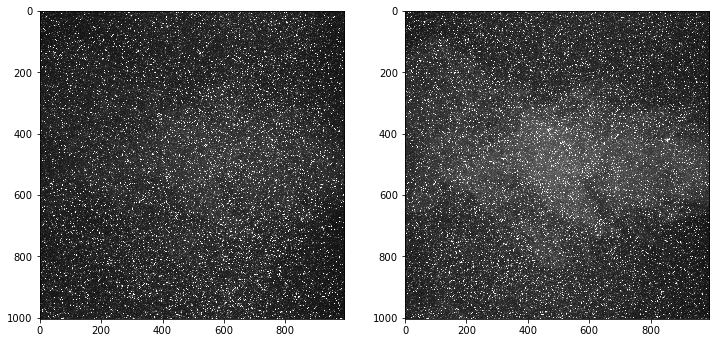

In [3]:
# Load and plot images to work on
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' + image_number + 'b.tif' )
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

# Standard contrast stretching


In [4]:
# Image equalization
def image_equalization(frame,dynamic_range = 255, plot = 0):
    frame = np.array(frame)
    # Histogram and cdf of the original image
    hist,bins = np.histogram(frame.flatten(),dynamic_range,[0,dynamic_range])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    
    #Image equalization
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*dynamic_range/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    frameEQ = cdf[frame]    
    
    # Histogram and cdf of the equalized image
    frameEQ = np.array(frameEQ)
    histEQ,binsEQ = np.histogram(frameEQ.flatten(),dynamic_range,[0,dynamic_range])
    cdfEQ = histEQ.cumsum()
    cdf_normalizedEQ = cdfEQ * histEQ.max()/ cdfEQ.max()
    
    # Plot
    if plot:
        # Oriinal image
        ax1 = plt.subplot(1,2,1)
        ax1.plot(cdf_normalized, color = 'b')
        ax1.hist(frame.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax1.set_xlim([0,dynamic_range])
        ax1.legend(('cdf','histogram'), loc = 'upper left')
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.plot(cdf_normalizedEQ, color = 'b')
        ax2.hist(frameEQ.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax2.set_xlim([0,dynamic_range])
        ax2.legend(('cdf','histogram'), loc = 'upper left')
        ax2.set_title('Equalized image')
        plt.show()
        
    return frameEQ

In [5]:
#frame_a = image_equalization(frame_a,dynamic_range,plot=1)
#frame_b = image_equalization(frame_b,dynamic_range,plot=1)

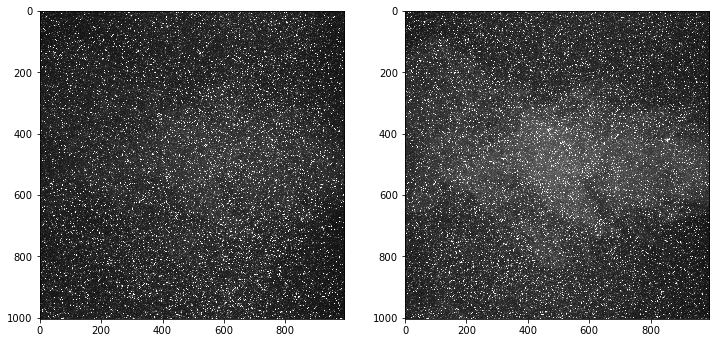

In [6]:
# Plot equalized images
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

# MinMax filtering

Definition of morphological operations

In [7]:
# # Basic morphological operations
# def dilate(frame, kernel):
#     shape = np.shape(frame)
#     shapek = np.shape(kernel)
#     #cycle on the figure
#     for i in range(0,shape[0]):
#         for j in range(0,shape[1]):
#             value = 0
#             # cycle on the kernel
#             for k in range(0,shapek[0]):
#                 for l in range(0,shapek[1]):
#                     if kernel[k,l] == 1:
#                         posx = i-k
#                         posx = min(posx,shape[0])
#                         posx = max(posx,0)
#                         posy = j-l
#                         posy = min(posx,shape[1])
#                         posy = max(posx,0)
#                         value = max(frame[posx,posy],value)
            
#             # Update the value of the frame
#             frame[i,j] = value
            
#     return frame


# def erode(frame, kernel):
#     shape = np.shape(frame)
#     shapek = np.shape(kernel)
#     #cycle on the figure
#     for i in range(0,shape[0]):
#         for j in range(0,shape[1]):
#             value = 0
#             # cycle on the kernel
#             for k in range(0,shapek[0]):
#                 for l in range(0,shapek[1]):
#                     if kernel[k,l] == 1:
#                         posx = i-k
#                         posx = min(posx,shape[0])
#                         posx = max(posx,0)
#                         posy = j-l
#                         posy = min(posx,shape[1])
#                         posy = max(posx,0)
#                         print('X = ' + str(posx) + '      Y = ' + str(posy))
#                         value = max(frame[posx,posy],value)
            
#             # Update the value of the frame
#             frame[i,j] = value
            
#     return frame
# # Kernels
# def cross(size, print_out = False):
#     if (size % 2) != 1:
#         print('Choose an odd size please')
        
#     out = np.zeros((size,size))
#     center = np.floor(size/2)
#     center = int(center)
#     out[center,:] = np.ones(size)
#     out[:,center] = np.ones(size)
    
#     if print_out:
#         plt.imshow(out)
    
#     return out

# def disk(radius, print_out = False):
#     # Not working
#     if (size % 2) != 1:
#         print('Choose an odd size please')
#     out = np.zeros((radius,radius))
#     for i in range(0,radius):
#         for j in range(0,radius):
#             k = abs(i - floor(radius/2))
#             l = abs(j - floor(radius/2))
#             out[i,j] = ((k*k+l*l) < radius*radius)
    
#     if print_out:
#         plt.imshow(out)
        
#     return out

# # Filters
# def myminmax(frame, kernel, plot = 0):
#     erosion = erode(frame,kernel)
#     dilation = dilate(frame, kernel)
#     out = (frame - erosion) / (dilation - erosion)
    
#     if plot:
#         # Oriinal image
#         ax1 = plt.subplot(1,2,1)
#         ax1.imshow(frame, cmap = plt.cm.gray)
#         ax1.set_title('Original image')
#         # Equalized image
#         ax2 = plt.subplot(1,2,2)
#         ax2.imshow(out, cmap = plt.cm.gray)
#         ax2.set_title('Filtered image')
#         plt.show()
        
#     return out


In [8]:
# # Test cell
# size = 9
# out = np.zeros((size,size))
# center = np.floor(size/2)+1
# center = int(center)
# print(center)
# out[center,:] = np.ones(size)
# out[:,center] = np.ones(size)

# disk(11)

In [9]:
selem = morphology.disk(70)
frame_a = rank.equalize(frame_a, selem=selem)
frame_b = rank.equalize(frame_b, selem=selem)

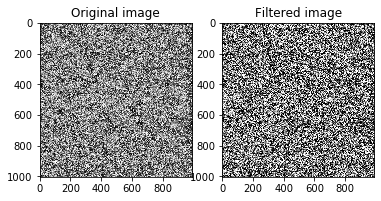

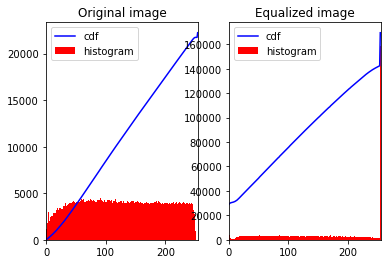

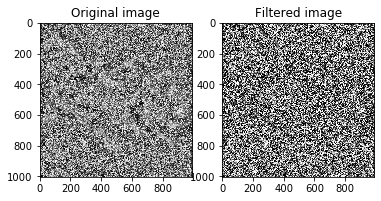

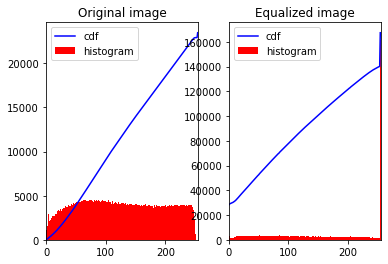

In [10]:
def skiminmax(frameIN, iterations =1, element = None, plot = 0, cdfplot=1):
    
    frame = np.copy(frameIN)
    erosion = np.copy(frameIN)
    dilation = np.copy(frameIN)
    
    for i in range(0,iterations):
        erosion = morphology.erosion(erosion, selem=element)
        dilation = morphology.dilation(dilation, selem=element)
    
    numerator = frame - erosion
    denominator = dilation - erosion
    denominator = np.maximum(denominator,1)
    out = numerator/denominator
    
    if plot:
        # Oriinal image
        ax1 = plt.subplot(1,2,1)
        ax1.imshow(frame, cmap = plt.cm.gray)
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.imshow(out, cmap = plt.cm.gray)
        ax2.set_title('Filtered image')
        plt.show()
        out = out * 255 / np.max(out)
        out = out.astype('uint8')
    if cdfplot:
        dynamic_range = 255
        # Histogram and cdf of the original image
        hist,bins = np.histogram(frame.flatten(),dynamic_range,[0,dynamic_range])
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max()/ cdf.max()  
    
        # Histogram and cdf of the filterd image
        histMM,binMM = np.histogram(out.flatten(),dynamic_range,[0,dynamic_range])
        cdfMM = histMM.cumsum()
        cdf_normalizedMM = cdfMM * histMM.max()/ cdfMM.max()

        # Plot image histogram
        ax1 = plt.subplot(1,2,1)
        ax1.plot(cdf_normalized, color = 'b')
        ax1.hist(frame.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax1.set_xlim([0,dynamic_range])
        ax1.legend(('cdf','histogram'), loc = 'upper left')
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.plot(cdf_normalizedMM, color = 'b')
        ax2.hist(out.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax2.set_xlim([0,dynamic_range])
        ax2.legend(('cdf','histogram'), loc = 'upper left')
        ax2.set_title('Equalized image')
        plt.show()
    return out

#element = morphology.selem.square(2)
element = None # default is a cross
frame_aminmax = skiminmax(frame_a,element=element, plot=1)
frame_bminmax = skiminmax(frame_b,element=element, plot=1)
#plt.imshow(element)
#frame_a = frame_aminmax
#frame_b = frame_bminmax
# print(' Mean    :    ' + str(np.mean(frame_aminmax)))
# print(' Maximum :    ' + str(np.max(frame_aminmax)))

In [11]:
# def minmax(frame, kernel_size, plot = 0, print_kernel = 0):
#     # Works but does not behave well as expected unless image equalization is on
#     kernel = np.ones((kernel_size,kernel_size))
#     # kernel = np.array([[0,0,1,0,0],[0,0,1,0,0],[1,1,1,1,1],[0,0,1,0,0],[0,0,1,0,0]])
#     if print_kernel:
#         print(kernel)
        
#     # Max
#     erosion = cv2.erode(frame,kernel, iterations = 1)    # Does the opposite because cv2 has strange standards
#     # Min
#     dilation = cv2.dilate(frame,kernel, iterations = 1)    # Does the opposite because cv2 has strange standards
    
#     numerator = np.subtract(frame, erosion)
#     denominator = np.subtract(dilation, erosion)
            
#     out = numerator/denominator
#     # plt.imshow(denominator,cmap=plt.cm.gray)
#     out = out * 255 / np.max(out)
#     # gradient = cv2.morphologyEx(frame, cv2.MORPH_GRADIENT, kernel)
    
#     if plot:
#         # Oriinal image
#         ax1 = plt.subplot(1,2,1)
#         ax1.imshow(frame, cmap = plt.cm.gray)
#         ax1.set_title('Original image')
#         # Equalized image
#         ax2 = plt.subplot(1,2,2)
#         ax2.imshow(out, cmap = plt.cm.gray)
#         ax2.set_title('Filtered image')
#         plt.show()
        
#     return out

# kernel_size = 11
# kernel = cross(kernel_size)
# frame_aminmax = minmax(frame_a,kernel_size, plot=1)
# frame_bminmax = minmax(frame_b,kernel_size, plot=1)
# # frame_aminmax = myminmax(frame_a,kernel, plot=1)
# # frame_bminmax = myminmax(frame_b,kernel, plot=1)

# frame_a = frame_aminmax
# frame_b = frame_bminmax

# print(' Mean    :    ' + str(np.mean(frame_aminmax)))
# print(' Maximum :    ' + str(np.max(frame_aminmax)))

# PIV analysis

In [12]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search in image B
overlap = 16 # pixels, 50% overlap
dt = 1/15 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [13]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

(array([ 78.,   0.,   0.,   0.,   0., 100., 374., 556., 439.,  93.]),
 array([0.        , 0.18401442, 0.36802884, 0.55204327, 0.73605769,
        0.92007211, 1.10408653, 1.28810095, 1.47211537, 1.6561298 ,
        1.84014422]),
 <a list of 10 Patch objects>)

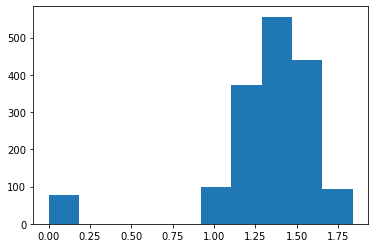

In [14]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
plt.hist(sig2noise.flatten())


In [15]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

In [16]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = scaling_factor )

In [17]:
#save in the simple ASCII table format
tools.save(x, y, u3, v3, sig2noise, mask, folder + '/Image_processing/' + technique + image_number + '.txt' )

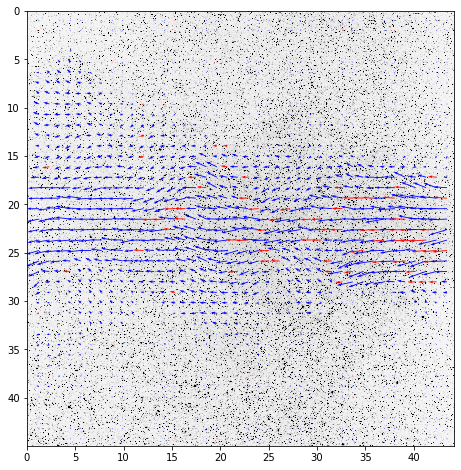

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field( folder + '/Image_processing/' + technique + image_number + '.txt', 
                           ax=ax, scaling_factor=scaling_factor, 
                           scale= 100, # scale defines here the arrow length
                           width= 0.002, # width is the thickness of the arrow
                           on_img= True, # overlay on the image
                           image_name= folder + '/Images/A' + image_number + 'a.tif');